In [13]:
from typing import Callable, List
from functools import partial, reduce

import numpy as np
from numpy import matmul
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
from numpy import ndarray

import scipy.optimize

plt.rcParams["figure.figsize"] = (20, 10)

In [14]:
"""
Finds gradient of function fun in point x with precision O(h^2).
"""
def grad(fun:Callable[[ndarray], float], x:ndarray, h:float=1e-5) -> ndarray:
    dim = len(x)
    g = np.zeros(dim)
    step = np.zeros(dim)
    for i in range(dim):
        step[i] = h
        g[i] = (fun(x + step) - fun(x - step)) / (2 * h)
        step[i] = 0
    return g

"""
@param args_num: number of function arguments (not parameters)
"""
class ParametrizedFun:
    def __init__(self, fun:Callable[[List[float], List[float]], float], args_num:int):
        self.fun = fun
        self.args_num = args_num

    def at_point(self, x:List[float]):
        return partial(self.fun, x)

    def with_params(self, b:List[float]):
        return partial(self.fun, b=b)

def np_map(fun:Callable[[List[float]], float], a:List[List[float]]) -> ndarray:
    return np.array(list(map(fun, a)))

def generate_dataset(parametrized_fun:ParametrizedFun, b:List[float], size:int=100, r:tuple=(-10, 10), deviation:float=1):
    eval_fun = parametrized_fun.with_params(b)
    features = np.random.rand(size, parametrized_fun.args_num) * (r[1] - r[0]) + r[0]
    error = np.random.normal(0, deviation, size)
    dependent_var = np_map(eval_fun, features) + error
    return [features, dependent_var]

class SumFun:
    def __init__(self, features:List[List[float]], dependent_var:List[float], fun:ParametrizedFun):
        self._fun = fun
        self.terms = np.empty(len(features), dtype=partial)
        self.r = np.empty(len(features), dtype=partial)
        for i in range(len(features)):
            self.r[i] = partial(lambda features, dependent_var, b: (fun.at_point(features))(b) - dependent_var, features[i], dependent_var[i])
            self.terms[i] = partial(lambda features, dependent_var, b: np.square(fun.at_point(features)(b) - dependent_var), features[i], dependent_var[i])
        self.fun = reduce(lambda f1, f2: lambda x: f1(x) + f2(x), self.terms)

    @classmethod
    def from_fun(cls, fun:Callable):
        f = ParametrizedFun(lambda x, b: fun(b), 0)
        features = [[]]
        dependent_var = [0]
        return SumFun(features, dependent_var, f)

    def evaluate_r(self, x:ndarray) -> List[float]:
        res = np.empty(len(self.r), dtype=float)
        for i in range(len(self.r)):
            res[i] = self.r[i](x)
        return res

    def r_grad(self, x:ndarray) -> ndarray:
        j = np.zeros((len(self.r), len(x)))
        for i in range(len(self.r)):
            j[i] = grad(self.r[i], x)
        return j

    def grad(self, x:ndarray) -> ndarray:
        return 2 * np.matmul(self.r_grad(x).transpose(), self.evaluate_r(x))

    def hess_appr(self, x:ndarray) -> ndarray:
        j = self.r_grad(x)
        return 2 * np.matmul(j.transpose(), j)

    def get_model(self, x:ndarray):
        fun = self.get_fun()(x)
        g = self.grad(x)
        h = self.hess_appr(x)
        return partial(lambda fun, g, h, p: fun + matmul(g.transpose(), p) + 1/2 * matmul(matmul(p.transpose(), h), p), fun, g, h)

    def get_fun(self):
        return self.fun

def gauss_newton(fun:SumFun, x:List[float], max_epoch:int, lr:float=1, stop_criteria:Callable[[List[List[float]]], bool]=lambda x: False) -> ndarray:
    points = [x]
    f = sum_fun.get_fun()
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        p = -matmul(inv(fun.hess_appr(x)), fun.grad(x))
        alpha = scipy.optimize.line_search(f, partial(grad, f), x, p, c1=1e-4, c2=0.9)
        if alpha[0] is None:
            x = x + lr * 1e-4 * p
        else:
            x = x + lr * alpha[0] * p
        points.append(x)
    return np.array(points)

def plot_path_contours(sum_fun:SumFun, points:List[List[float]], offset:float=None) -> None:
    min_point = points[-1]
    ax = plt.figure(figsize=(20, 20)).add_subplot()
    ax.plot(points[:, 0], points[:, 1], 'o-')
    fun = sum_fun.get_fun()
    if offset is None:
        offset = np.max(min_point) * 1.2
    ttX = np.linspace(min_point[0] - offset, min_point[0] + offset, 200)
    ttY = np.linspace(min_point[1] - offset, min_point[1] + offset, 200)
    X, Y = np.meshgrid(ttX, ttY)
    plt.title('Descent path and level curves', fontsize=22)
    ax.contour(X, Y, fun([X, Y]), levels=np.sort(np.unique([fun(point) for point in points])))

def print_result(points:ndarray, actual_min:ndarray=None, min_point:float=None) -> None:
    if min_point is None:
        min_point = points[-1]
    if actual_min is None:
        print(f'Precision: unknown')
    else:
        print(f'Precision: {actual_min - min_point}')
    print(f'Min point: {min_point}')
    print(f'Iterations: {len(points)}')
    print(f'Path: {points}')

def bin_search(fun:Callable[[float], float], c:float, eps:float=1e-3, r:tuple=(0, 1)):
    left, right = r
    while right - left > eps:
        mid = (left + right) / 2
        if fun(mid) < c:
            left = mid
        else:
            right = mid
    return (left + right) / 2

def dogleg(fun:SumFun, x:List[float], max_epoch:int, delta:float, min_delta:float=0, max_delta:float=1e2,stop_criteria:Callable[[List[List[float]]], bool]=lambda x: False) -> ndarray:
    points = [x]
    f = fun.get_fun()
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        g = fun.grad(x)
        h = fun.hess_appr(x)
        # print("h", h)
        b = -matmul(inv(h), g)
        if norm(b) <= delta:
            p = b
        else:
            a = -matmul(g.transpose(), g) / matmul(matmul(g.transpose(), h), g) * g
            if norm(a) > delta:
                p = delta / norm(a) * a
            else:
                ff = lambda t: norm(a + t * (b - a))
                p = a + bin_search(ff, delta) * (b - a)
        m = fun.get_model(x)
        k = (f(x) - f(x + p)) / (m(np.zeros(len(p)) - m(p)))
        x = x + p
        if k < 0.25:
            delta = max(delta / 4, min_delta)
        elif np.abs(norm(p) - delta) < 1e-5:
            delta = min(2 * delta, max_delta)
        points.append(x)
    return np.array(points)

def calc_next_h(h, s, y):
    r = 1 / matmul(y.transpose(), s)
    v = np.identity(len(s)) - r * matmul(y, s.transpose())
    return matmul(matmul(v.transpose(), h), v) + r * matmul(s, s.transpose())

def calc_next_p(s:ndarray, y:ndarray, g:ndarray) -> ndarray:
    q = g
    alpha = np.zeros(len(s))
    ro = np.zeros(len(s))
    for i in range(len(s) - 1, -1, -1):
        ro[i] = 1 / matmul(y[i].transpose(), s[i])
        alpha[i] = ro[i] * matmul(s[i].transpose(), q)
        q = q - alpha[i] * y[i]
    if len(s) > 0:
        h = matmul(s[-1].transpose(), y[-1]) / matmul(y[-1].transpose(), y[-1]) * np.identity(len(g))
    else:
        h = np.identity(len(g))
    r = matmul(h, q)
    for i in range(len(s)):
        beta = ro[i] * matmul(y[i].transpose(), r)
        r = r + s[i] * (alpha[i] - beta)
    return -r

def bfgs(fun:SumFun, x:ndarray, max_epoch:int, h0:ndarray=None, stop_criteria:Callable[[List[List[float]]], bool]=lambda x: False) -> ndarray:
    points = [x]
    if h0 is None:
        h = inv(fun.hess_appr(x))
    else:
        h = h0
    f = fun.get_fun()
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        g = sum_fun.grad(x)
        p = -matmul(h, g)
        alpha = scipy.optimize.line_search(f, partial(grad, f), x, p, c1=1e-4, c2=0.9)
        if alpha[0] is None:
            x_next = x + 1e-4 * p
        else:
            x_next = x + alpha[0] * p

        s = x_next - x
        y = sum_fun.grad(x_next) - g
        h = calc_next_h(h, s, y)

        x = x_next
        points.append(x)
    return np.array(points)

def l_bfgs(fun:SumFun, x:ndarray, max_epoch:int, m:int=4, stop_criteria:Callable[[List[List[float]]], bool]=lambda p: len(p) > 1 and (np.abs(p[-1] - p[-2]) < 1e-4).all()) -> ndarray:
    points = [x]
    f = fun.get_fun()
    s = []
    y = []
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        g = sum_fun.grad(x)
        p = calc_next_p(s, y, g)
        alpha = scipy.optimize.line_search(f, fun.grad, x, p, c1=1e-4, c2=0.9)
        # Иначе может упасть, если stop_criteria плохой
        if alpha[0] is None:
            x_next = x + 1e-4 * p
        else:
            x_next = x + alpha[0] * p

        s.append(x_next - x)
        y.append(sum_fun.grad(x_next) - g)
        if len(s) > m:
            s.pop(0)
            y.pop(0)

        x = x_next
        points.append(x)
    return np.array(points)

def grad_appr(fun:List[Callable[[ndarray], float]], x:ndarray, r:List=(0, 1), h:float=1e-5) -> ndarray:
    sum = np.zeros(len(x))
    begin = r[0]
    n = r[1]
    for i in range(n):
        sum += grad(fun[(begin + i) % len(fun)], x, h)
    return sum

def sgd_adam(sum_fun:SumFun, x:ndarray, max_epoch:int, batch_size:int, lr:List[float], b1:List[float], b2:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr, stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    b1, b2 = np.array(b1), np.array(b2)
    points = [x]
    m = 0
    v = 0
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        g = np.array(grad_appr(sum_fun.terms, x, [(i - 1) * batch_size, batch_size]))

        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * np.square(g)

        m = m / (1 - np.power(b1, i))
        v = v / (1 - np.power(b2, i))

        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * m
        points.append(x)
    return np.array(points)

In [15]:
from timeit import default_timer as timer

def test(sum_fun, tested_function, x, title="Unknown", max_epoch=200):
    stop_criteria = lambda p: len(p) > 1 and (np.abs(p[-1] - p[-2]) < 1e-3).all()
    start_time = timer()
    points = tested_function(sum_fun, x, max_epoch, stop_criteria=stop_criteria)
    time = timer() - start_time
    print(title)
    print(f'Deviation: {b - points[-1]}')
    print(f'Epochs: {len(points)}')
    print(f'Elapsed time: {time * 1000} ms')
    print(f'Time on epoch: {time / len(points) * 1000} ms\n')

n = 2
#Rosenbrock
b = [1, 100]
rosenbrock = lambda x: np.square(1 - x[0]) + 100 * np.square(x[1] - np.square(x[0]))
sum_fun = SumFun.from_fun(rosenbrock)

print("Rosenbrock function")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")

# Function from first lecture
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-1, 1))
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print("Function from first lecture")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Gauss-Newton")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

# Euclid distance
b = [4, 3]
parametrized_fun = ParametrizedFun(lambda x, b: np.sqrt((b[0] - x[0])**2 + (b[1] - x[1])**2), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=1000, deviation=0.5)
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print("Euclid distance function")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Gauss-Newton")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

# Lineal function (two parameters)
b = [10, -4]
parametrized_fun = ParametrizedFun(lambda x, b: b[0] + b[1] * x[0], 1)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-10, 10))
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print("Lineal function (two params)")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Gauss-Newton")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

stop_criteria = lambda p: len(p) > 1 and (np.abs(p[-1] - p[-2]) < 1e-3).all()
start_time = timer()
# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = 60
b1 = 0.5
b2 = 0.7
scheduler = lambda lr: lr * np.exp(-0.05)
points = sgd_adam(sum_fun, x, epoch, batch_size, lr, b1, b2, scheduler=scheduler)
time = timer() - start_time
print("Adam")
print(f'Deviation: {b - points[-1]}')
print(f'Epochs: {len(points)}')
print(f'Elapsed time: {time * 1000} ms')
print(f'Time on epoch: {time / len(points) * 1000} ms\n')

# Lineal function (20 parameters)
n = 20
b = np.random.rand(n) * 20 - 10
parametrized_fun = ParametrizedFun(lambda x, b: b[0] + np.sum(b[1:] * x), n - 1)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-10, 10))
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print(f'Lineal function ({n} params)')
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Gauss-Newton")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

BFGS
Deviation: [-0.01042876  0.05590908]
Epochs: 200
Elapsed time: 12234.709699987434 ms
Time on epoch: 61.17354849993717 ms

Gauss-Newton
Deviation: [ 5.75928194e-13 -6.99174052e-12]
Epochs: 7
Elapsed time: 139.37960006296635 ms
Time on epoch: 19.911371437566622 ms

Dogleg
Deviation: [9.93649607e-15 2.53796983e-13]
Epochs: 11
Elapsed time: 272.08740008063614 ms
Time on epoch: 24.735218189148743 ms

Euclid distance function
L-BFGS
Deviation: [-0.01824757  0.03338136]
Epochs: 6
Elapsed time: 874.4940999895334 ms
Time on epoch: 145.74901666492224 ms

BFGS
Deviation: [-0.01828042  0.03328444]
Epochs: 8
Elapsed time: 1163.9496999559924 ms
Time on epoch: 145.49371249449905 ms

Gauss-Newton
Deviation: [-0.01824757  0.03338133]
Epochs: 5
Elapsed time: 551.3823000947013 ms
Time on epoch: 110.27646001894027 ms

Dogleg
Deviation: [-0.01824793  0.03338414]
Epochs: 19
Elapsed time: 2807.6125000370666 ms
Time on epoch: 147.7690789493193 ms

Lineal function (two params)
L-BFGS
Deviation: [0. 0.]
Ep

## L-BFGS with rosenbrock

Precision: [0.45621066 0.71461831]
Min point: [0.54378934 0.28538169]
Iterations: 50
Path: [[0.         0.        ]
 [0.18886498 0.        ]
 [0.18389465 0.04185688]
 [0.20104053 0.0297521 ]
 [0.20799802 0.04800501]
 [0.22399266 0.04090484]
 [0.2368437  0.07069696]
 [0.25971307 0.04773295]
 [0.25804623 0.06754748]
 [0.28136544 0.06620398]
 [0.28263052 0.08530203]
 [0.2947809  0.07958748]
 [0.30375941 0.09977003]
 [0.31549064 0.0927976 ]
 [0.32408744 0.11131308]
 [0.33469635 0.10596345]
 [0.34405094 0.12412101]
 [0.36151211 0.11620017]
 [0.35870946 0.13367315]
 [0.37319117 0.12796009]
 [0.37244502 0.14078455]
 [0.38328194 0.13937917]
 [0.38602999 0.15331841]
 [0.39757115 0.14957383]
 [0.39828362 0.15943291]
 [0.41494848 0.16013907]
 [0.41278995 0.17181431]
 [0.42900217 0.17135001]
 [0.42622457 0.18263578]
 [0.43969435 0.18313607]
 [0.43831603 0.19242961]
 [0.45038236 0.19416593]
 [0.44983334 0.20233815]
 [0.46159518 0.20481454]
 [0.461165   0.21258735]
 [0.47247569 0.21528946]
 [0.47179

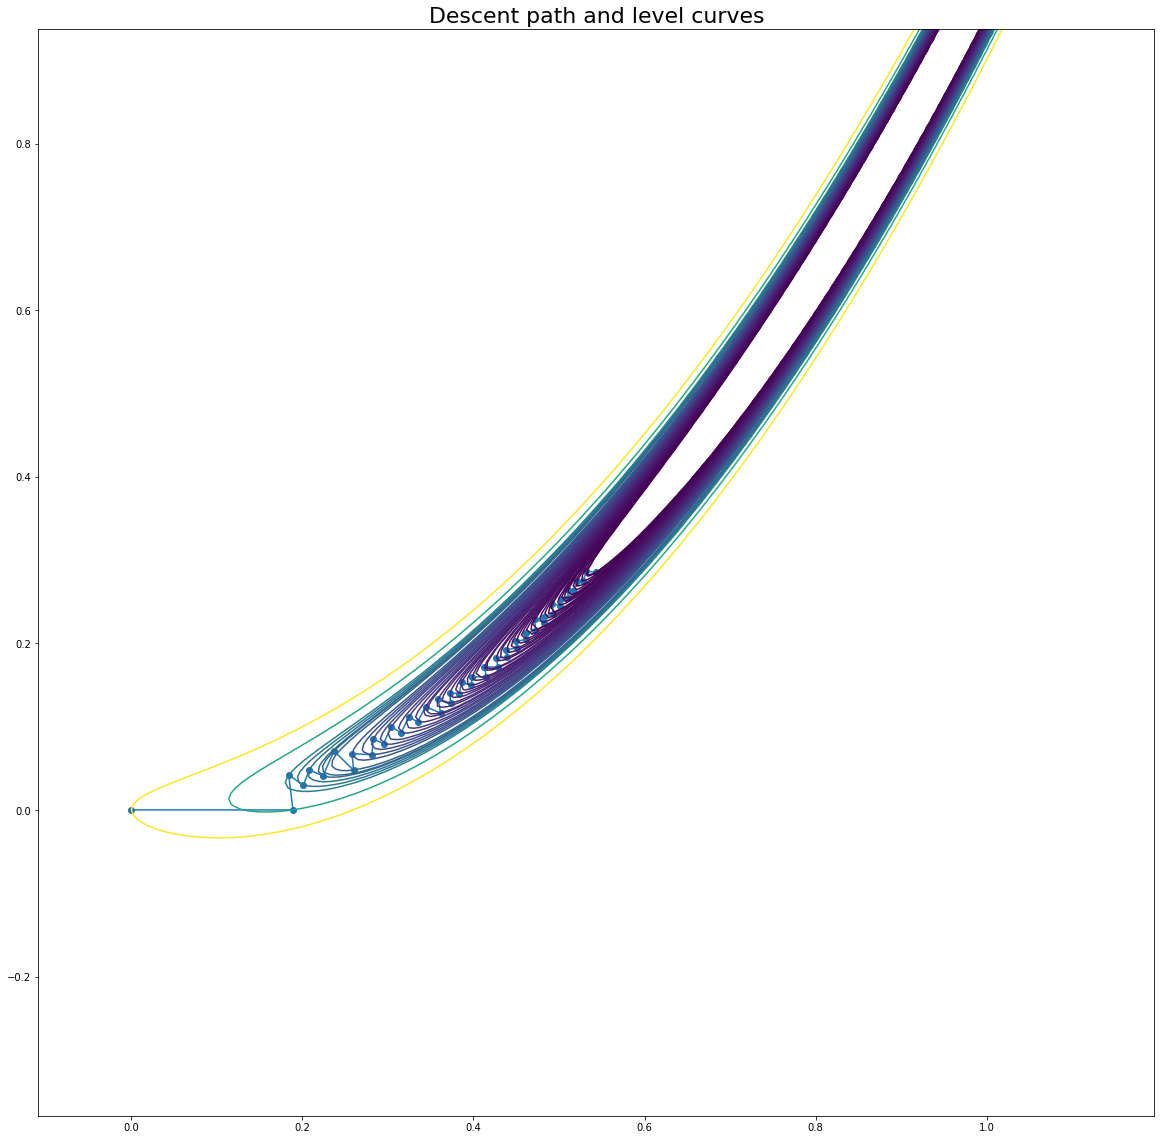

In [16]:
rosenbrock = lambda x: np.square(1 - x[0]) + 100 * np.square(x[1] - np.square(x[0]))

sum_fun = SumFun.from_fun(rosenbrock)
x = np.zeros(2)
points = bfgs(sum_fun, x, 50, h0=np.identity(len(x)))

min_point = np.array([1, 1])
print_result(points, min_point)
plot_path_contours(sum_fun, points)

## L-BFGS

Precision: [1.27668640e-08 2.31706855e-06]
Min point: [0.49999999 1.99999768]
Iterations: 10
Path: [[0.         0.        ]
 [0.21463715 0.01207002]
 [0.22129005 0.02477795]
 [0.24676555 0.13020546]
 [0.49243752 1.88412852]
 [0.50555304 1.97316159]
 [0.506426   1.9897362 ]
 [0.50250233 1.99664442]
 [0.50000154 1.99991633]
 [0.49999999 1.99999768]]


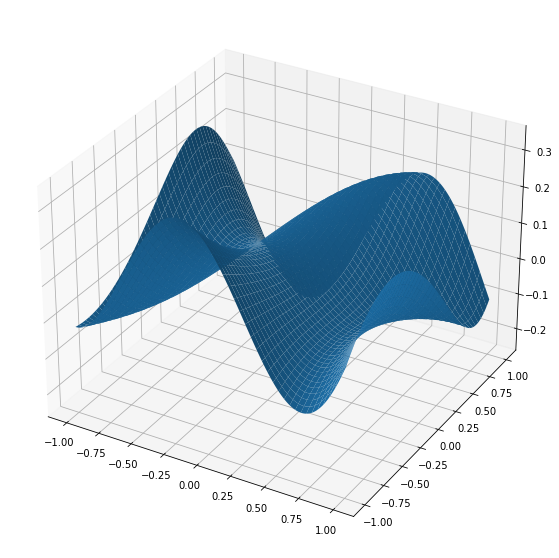

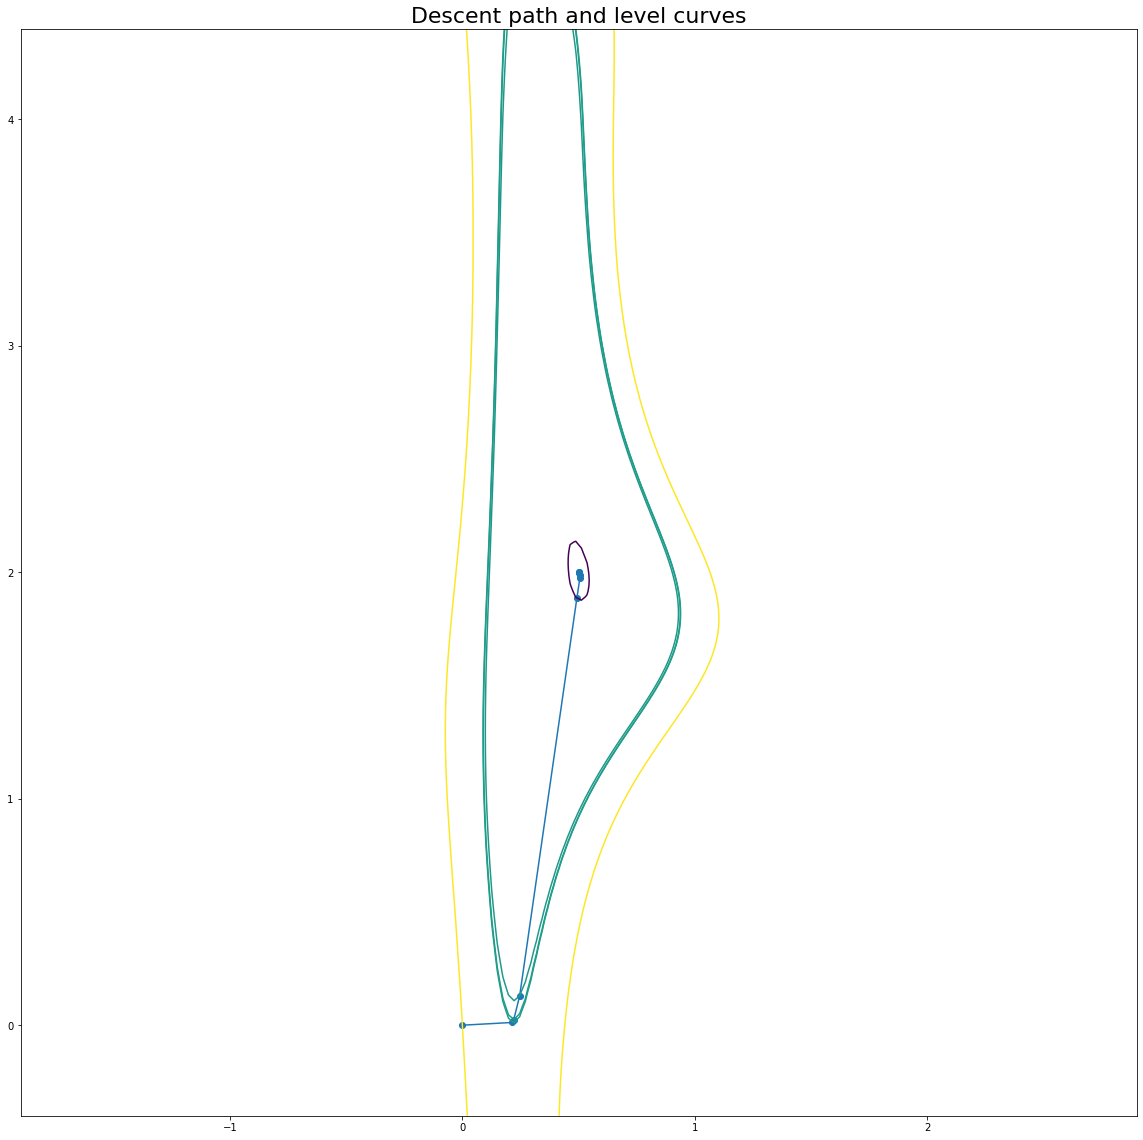

In [17]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = l_bfgs(sum_fun, x, 50)

print_result(points, b)
plot_path_contours(sum_fun, points)

## BFGS

Precision: [0.26549249 1.86611913]
Min point: [0.23450751 0.13388087]
Iterations: 50
Path: [[ 0.          0.        ]
 [ 0.22061048 -0.08896837]
 [ 0.21520661 -0.08867189]
 [ 0.23061414  0.05841263]
 [ 0.22602814  0.05555122]
 [ 0.231194    0.06296837]
 [ 0.22642991  0.05984409]
 [ 0.23156525  0.06734507]
 [ 0.22674533  0.06410418]
 [ 0.23182269  0.07155739]
 [ 0.22702043  0.06828032]
 [ 0.23202286  0.07561788]
 [ 0.22727368  0.07234397]
 [ 0.23219471  0.07953816]
 [ 0.22751322  0.07628533]
 [ 0.23235222  0.08332864]
 [ 0.22774297  0.08010443]
 [ 0.23250198  0.08699852]
 [ 0.22796496  0.08380567]
 [ 0.23264713  0.09055602]
 [ 0.22818034  0.08739501]
 [ 0.23278915  0.09400849]
 [ 0.22838984  0.09087884]
 [ 0.23292876  0.09736255]
 [ 0.22859396  0.09426334]
 [ 0.23306635  0.1006242 ]
 [ 0.22879311  0.09755436]
 [ 0.2332021   0.10379889]
 [ 0.2289876   0.10075731]
 [ 0.23333612  0.10689158]
 [ 0.22917771  0.10387719]
 [ 0.2334685   0.10990682]
 [ 0.22935569  0.10691276]
 [ 0.23358565  0.1

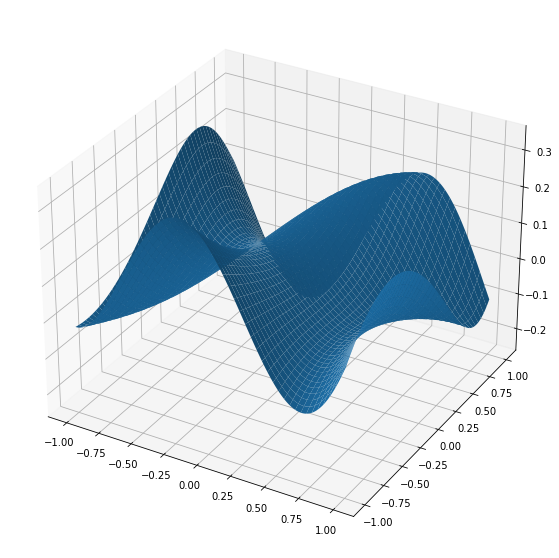

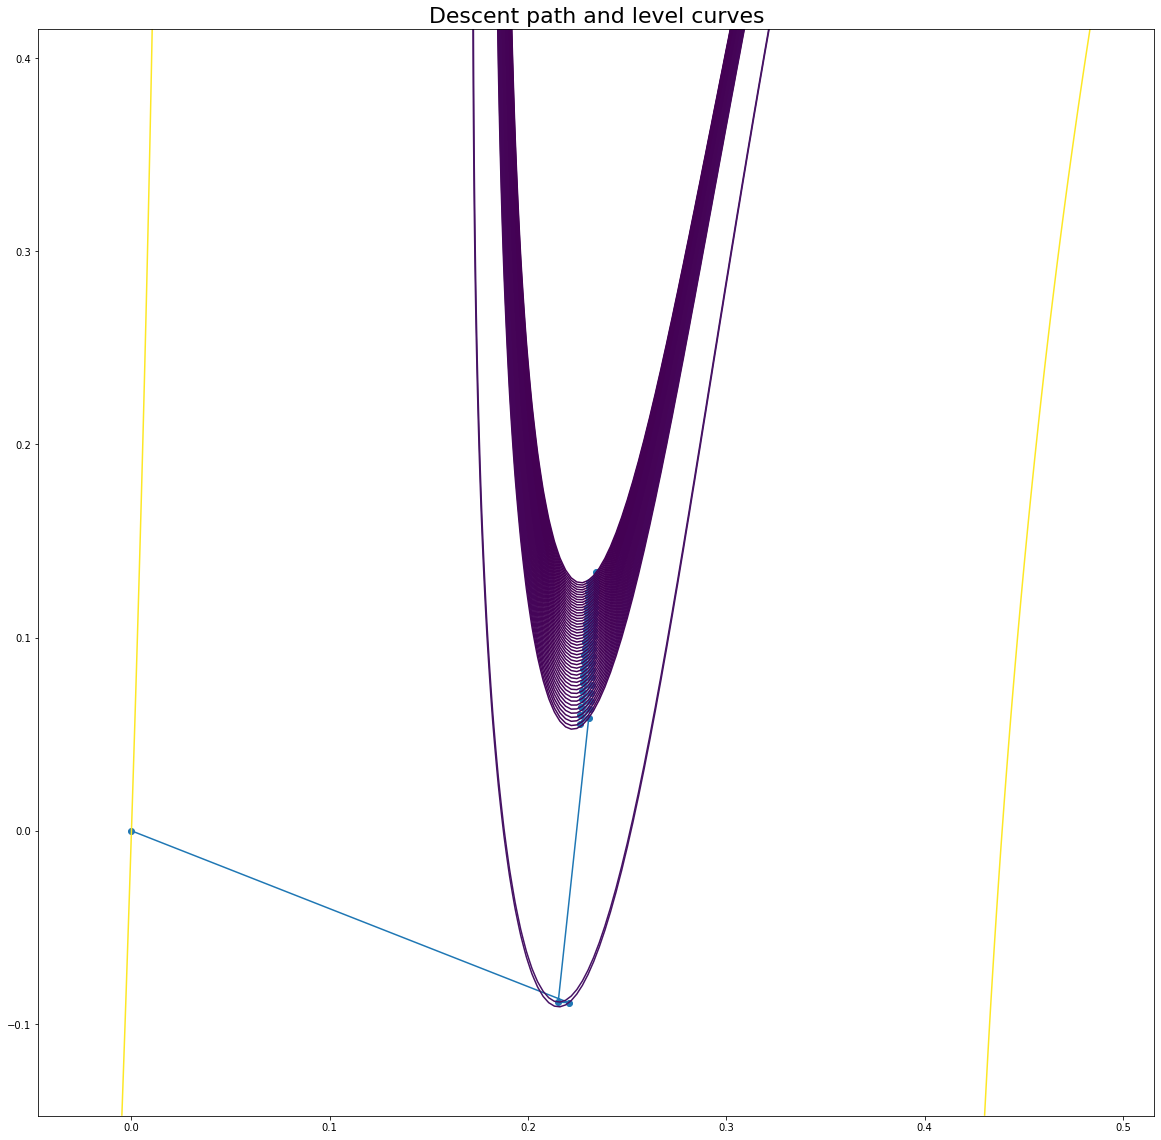

In [18]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0.05, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = bfgs(sum_fun, x, 50)

print_result(points, b)
plot_path_contours(sum_fun, points)

## Dogleg

Precision: [-0.00576825 -0.02019603]
Min point: [0.50576825 2.02019603]
Iterations: 20
Path: [[0.         0.        ]
 [0.29322336 0.00864055]
 [0.26358813 0.25687918]
 [0.30196297 0.50406285]
 [0.32486952 0.75306285]
 [0.35420088 1.0018566 ]
 [0.39761141 1.247612  ]
 [0.42933923 1.49559052]
 [0.49202162 1.73771203]
 [0.48529177 1.98761841]
 [0.50532949 2.02139642]
 [0.50578439 2.02009342]
 [0.50576697 2.02020226]
 [0.50576833 2.02019562]
 [0.50576824 2.02019606]
 [0.50576825 2.02019603]
 [0.50576825 2.02019603]
 [0.50576825 2.02019603]
 [0.50576825 2.02019603]
 [0.50576825 2.02019603]]


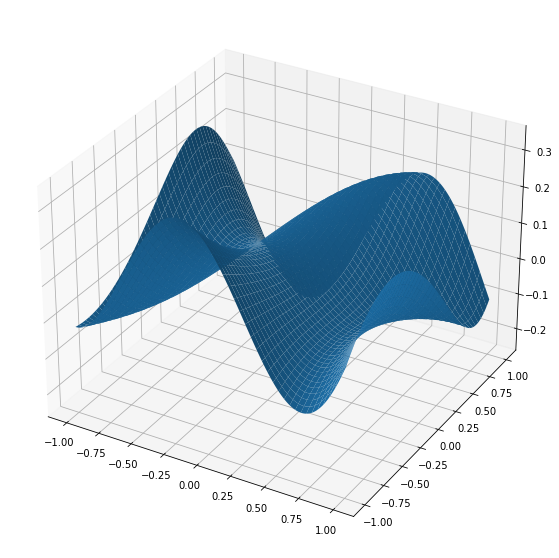

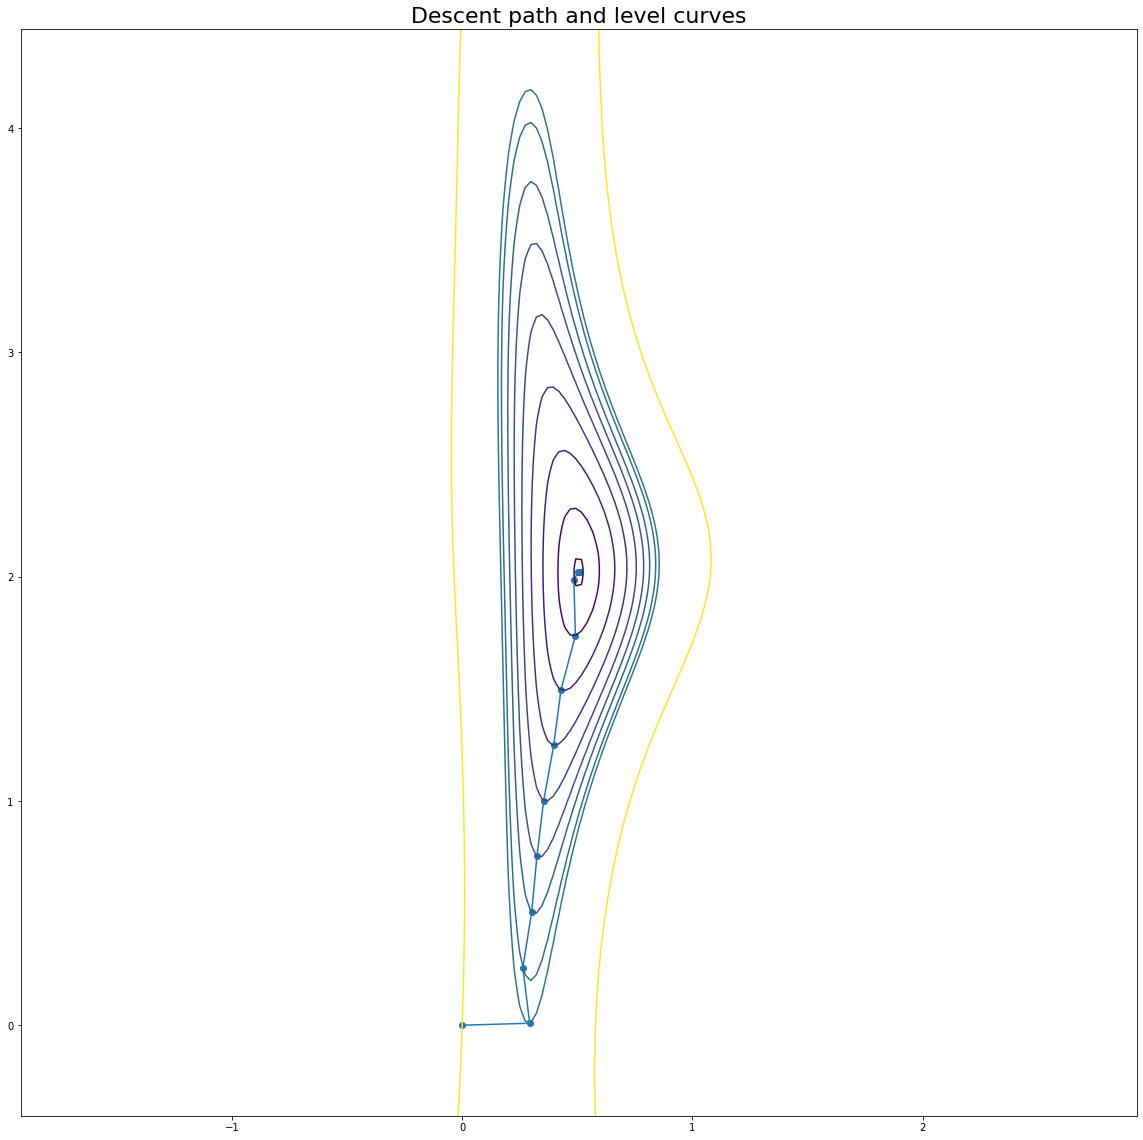

In [19]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0.05, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = dogleg(sum_fun, x, 20, 1, min_delta=0.25)

print_result(points, b)
plot_path_contours(sum_fun, points)

## Gauss-Newton

C:\Users\super\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Precision: [0.022128   0.00169836]
Min point: [3.977872   2.99830164]
Iterations: 20
Path: [[0.         0.        ]
 [3.52832261 2.5338052 ]
 [3.98058873 2.98982698]
 [3.97785914 2.99824325]
 [3.97787207 2.99830119]
 [3.977872   2.99830164]
 [3.977872   2.99830164]
 [3.977872   2.99830164]
 [3.977872   2.99830164]
 [3.977872   2.99830164]
 [3.977872   2.99830164]
 [3.977872   2.99830164]
 [3.977872   2.99830164]
 [3.977872   2.99830164]
 [3.977872   2.99830164]
 [3.977872   2.99830164]
 [3.977872   2.99830164]
 [3.977872   2.99830164]
 [3.977872   2.99830164]
 [3.977872   2.99830164]]


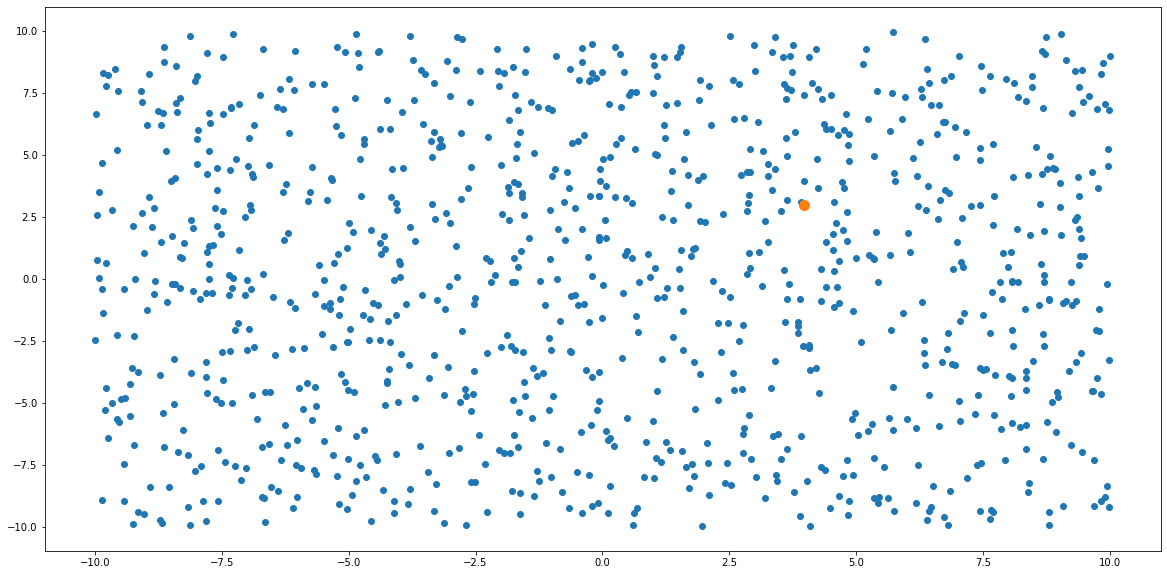

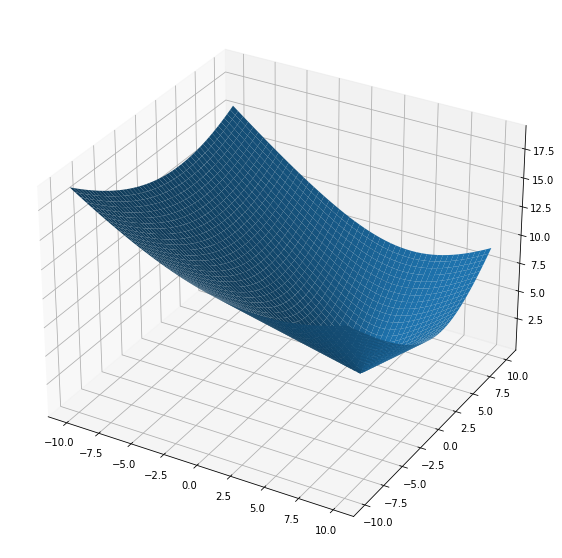

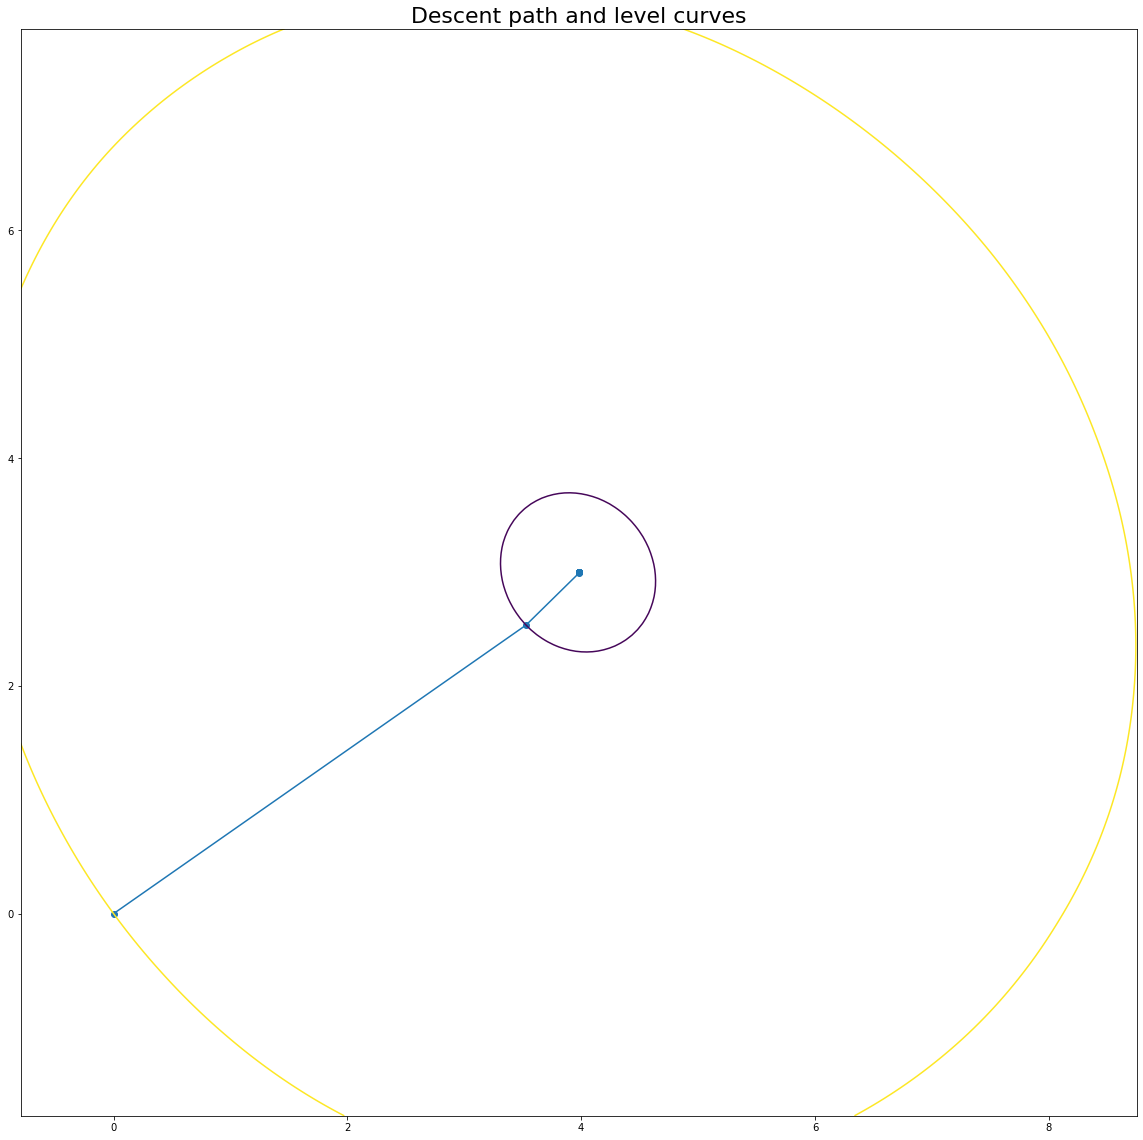

In [20]:
b = [4, 3]
parametrized_fun = ParametrizedFun(lambda x, b: np.sqrt((b[0] - x[0])**2 + (b[1] - x[1])**2), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=1000, deviation=0.5)
ax1 = plt.figure().add_subplot()
ax1.scatter(features[:, 0], features[:, 1])

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = gauss_newton(sum_fun, x, 20)

print_result(points, b)
ax1.scatter(points[-1][0], points[-1][1], marker="o", linewidths=5)
plot_path_contours(sum_fun, points)

## Практическая задача

Precision: unknown
Min point: [0.62915112 0.09682504]
Iterations: 20
Path: [[0.         0.        ]
 [0.09940681 0.00918806]
 [0.18384332 0.01850134]
 [0.25553558 0.02765036]
 [0.316398   0.03631522]
 [0.36806871 0.04429339]
 [0.41193926 0.05151445]
 [0.44918862 0.05798875]
 [0.48081599 0.0637637 ]
 [0.50766885 0.06889979]
 [0.5304666  0.07345938]
 [0.54982013 0.07750199]
 [0.56624834 0.08108252]
 [0.58019207 0.08425087]
 [0.59202584 0.087052  ]
 [0.60206787 0.08952631]
 [0.61058851 0.09171001]
 [0.61781741 0.09363553]
 [0.6239497  0.09533189]
 [0.62915112 0.09682504]]


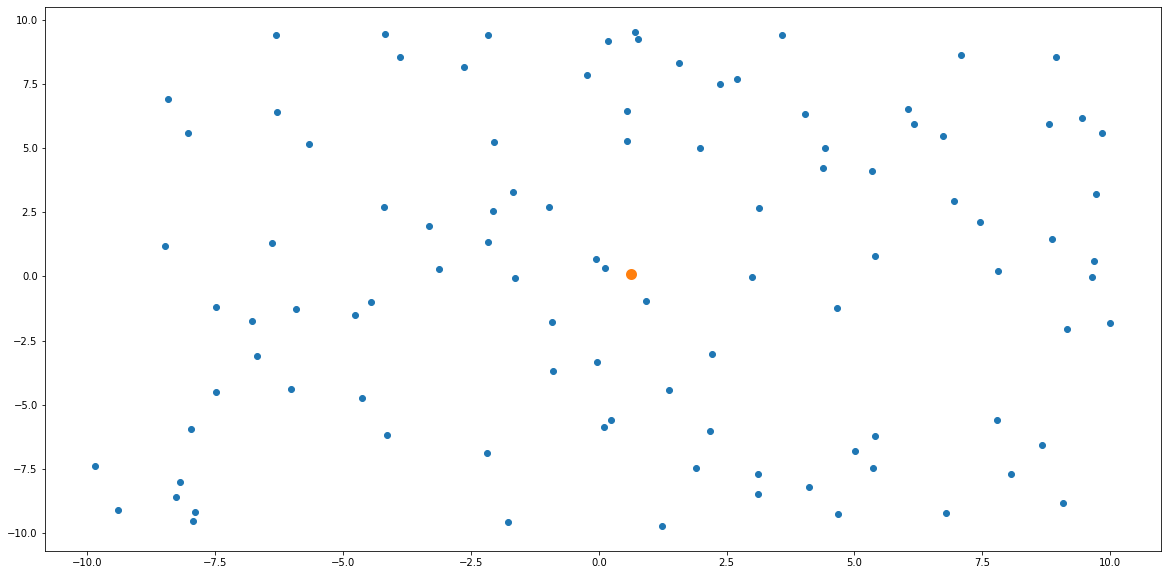

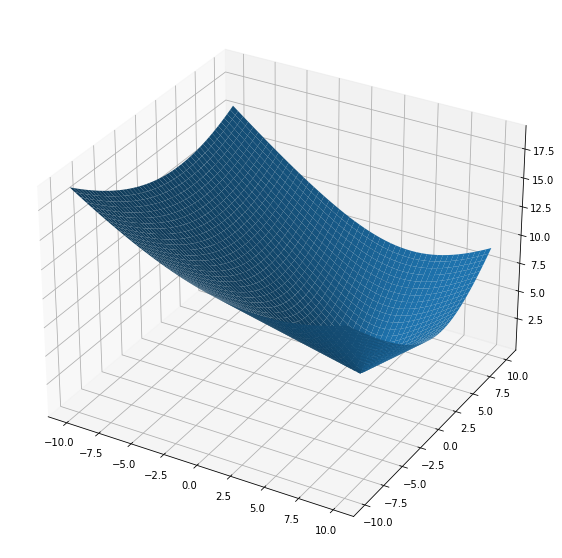

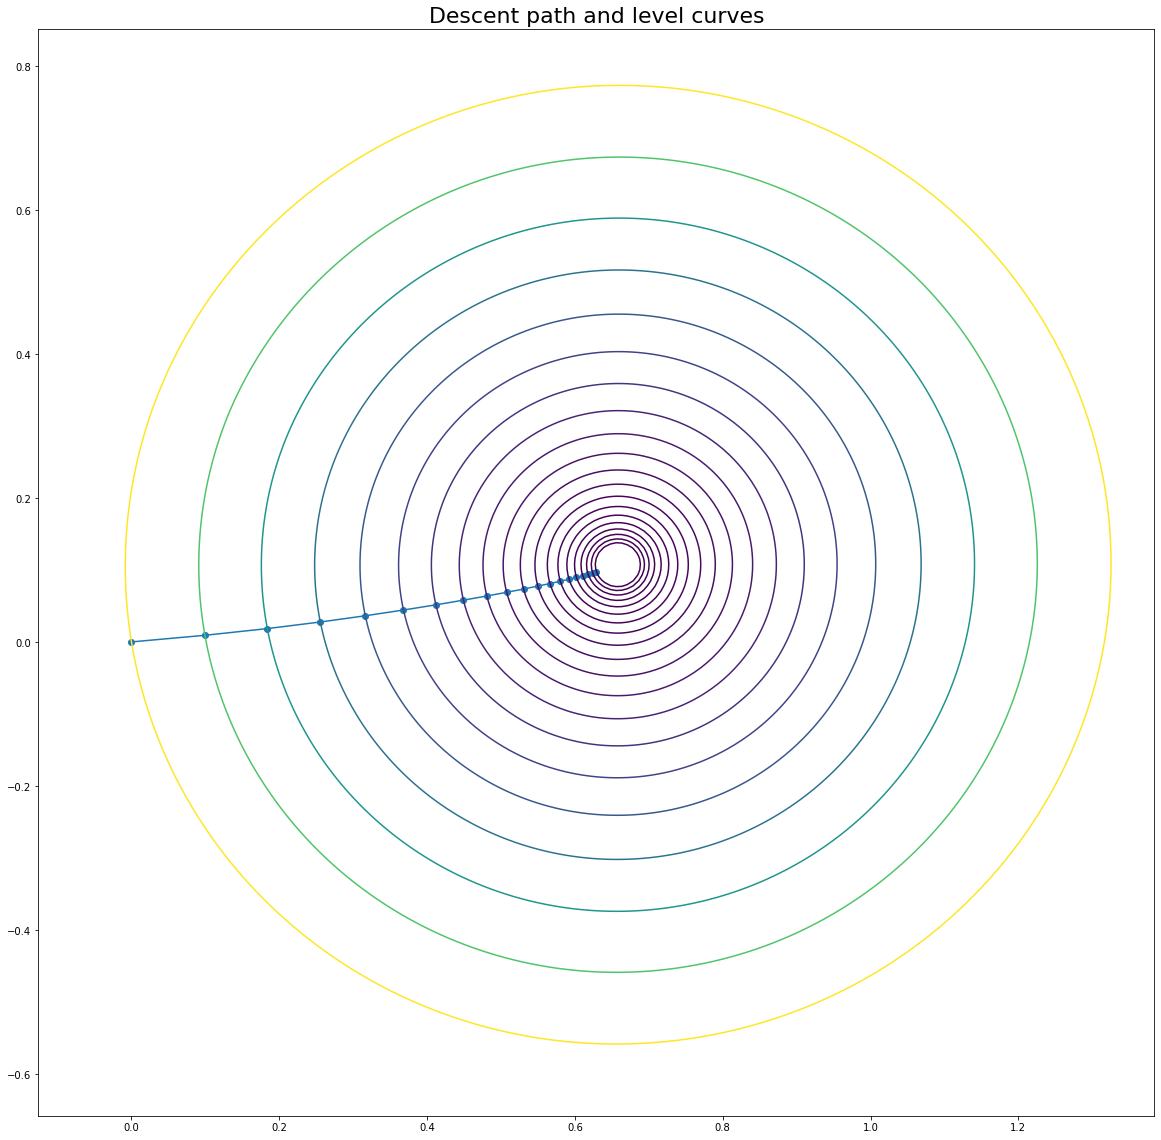

In [21]:
parametrized_fun = ParametrizedFun(lambda x, b: np.sqrt((b[0] - x[0])**2 + (b[1] - x[1])**2), 2)
features, dependent_var = generate_dataset(ParametrizedFun(lambda x, b: 0, 2), [0, 0], size=100, deviation=0.5)
ax1 = plt.figure().add_subplot()
ax1.scatter(features[:, 0], features[:, 1])

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
lr = 0.15
points = gauss_newton(sum_fun, x, 20, lr)

print_result(points)
ax1.scatter(points[-1][0], points[-1][1], marker="o", linewidths=5)
plot_path_contours(sum_fun, points)

## Очень нелинейная функция

Precision: [0. 0.]
Min point: [0.5 2. ]
Iterations: 20
Path: [[0.         0.        ]
 [0.32599232 0.13198424]
 [0.33071346 1.43389348]
 [0.46502123 2.0691966 ]
 [0.5000086  1.99305378]
 [0.49999809 1.99999814]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]]


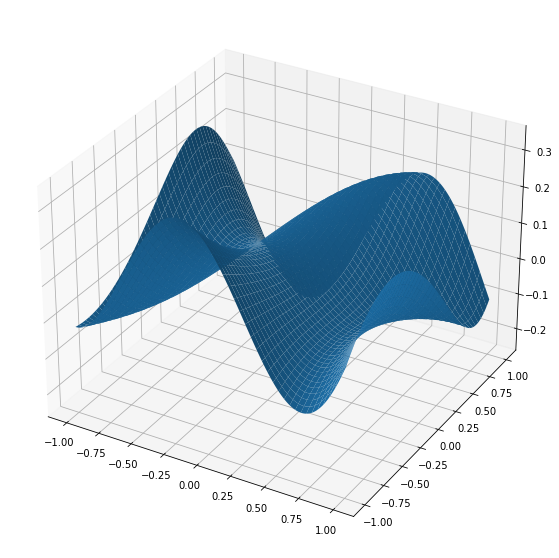

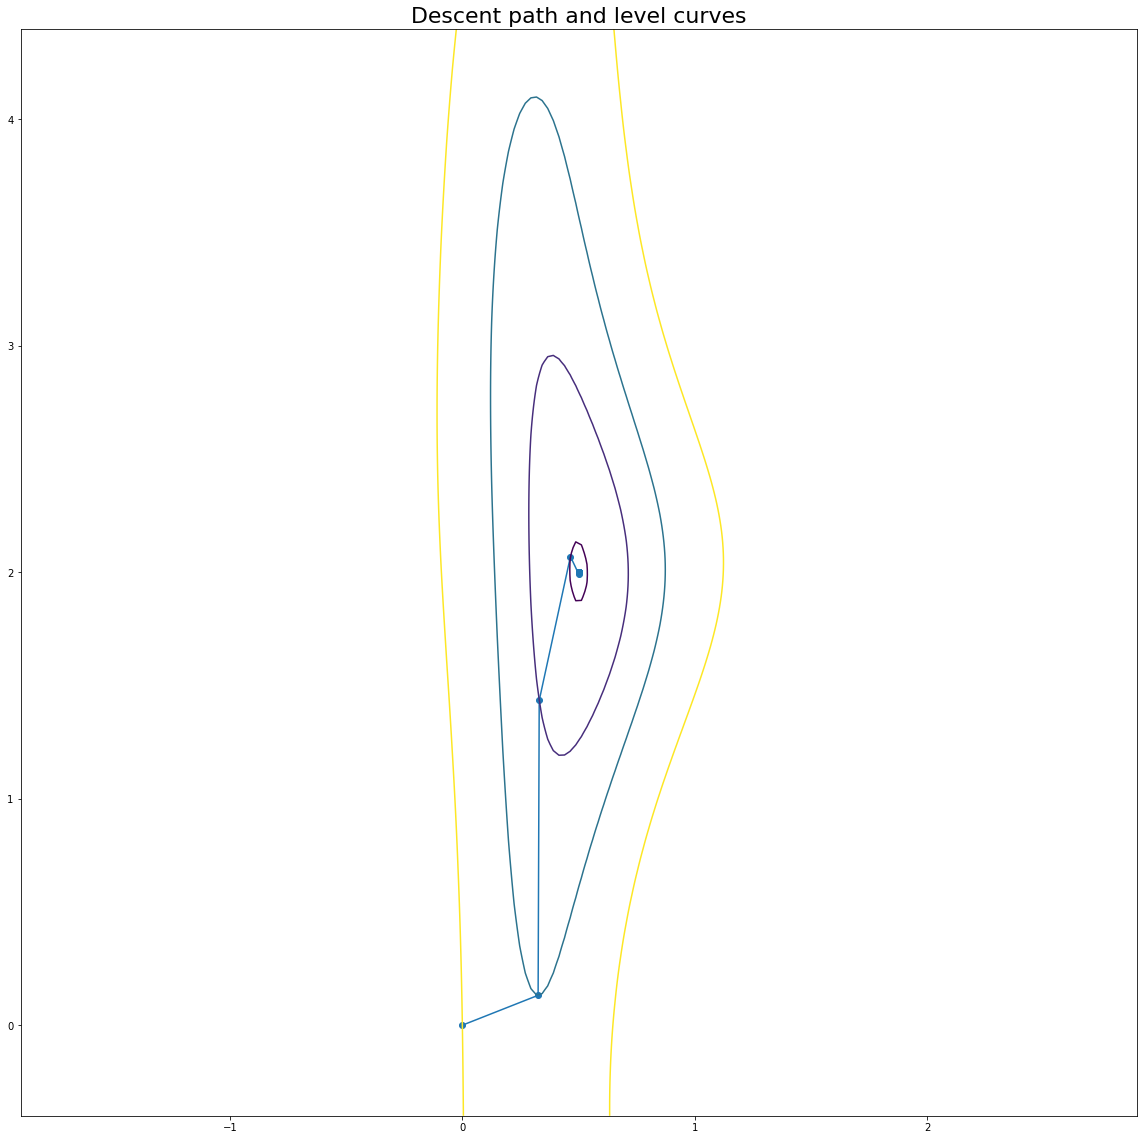

In [22]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x, b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y]))

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = gauss_newton(sum_fun, x, 20)

print_result(points, b)
plot_path_contours(sum_fun, points)